In [ ]:
import pandas as pd
import re
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
from visualization_tools.vvg_loader import vvg_to_df
from tools.get_coords_and_info import get_info_graph
from visualization_tools.vvg_colored_graph import colored_graph
from matplotlib import colors
from skimage import morphology
import matplotlib.colors as mcolors

def _load_data_graph(edges_file, json_dir):
        """Helper function to load graph data from CSV and JSON files."""
        data_edges_graph = pd.read_csv(edges_file, delimiter=';')
        json_edges, json_nodes = vvg_to_df(json_dir)
        return data_edges_graph, json_edges


def idxs_gt(X):
    final_idxs = {}
    for i in range(len(X)):
        point1 = i  # we are matching graph 1 to graph 2!!!
        point2 = torch.argmax(X[i]).item()
        if X[i,point2] == 1: # otherwise there is no match
            final_idxs[point1] = point2
    return final_idxs

In [2]:

def labeled_cl_graph(base_img, graph_points, labels):
    labeled_centerline = np.zeros_like(base_img)
    dict_labels = {}

    for vessel in graph_points:
        vessel_coords = np.array(graph_points[vessel]['centerline'])
        vessel_coords = np.round(vessel_coords).astype(int)
        labeled_centerline[vessel_coords[:, 0], vessel_coords[:, 1]] = labels[vessel]
        dict_labels[vessel] = labels[vessel]

    return labeled_centerline, dict_labels

def labeled_cl_solution(base_img, graph_points, ground_truth, prediction):
    labeled_centerline = np.zeros(base_img.shape)
    dict_labels = {}

    for vessel in graph_points:
        vessel_coords = np.array(graph_points[vessel]['centerline'])
        vessel_coords = np.round(vessel_coords).astype(int)

        # Compare the prediction to ground truth
        # label 1 for true positive, 2 for false positive, 3 for false negative
        if vessel in ground_truth and vessel in prediction:
            if ground_truth[vessel] == prediction[vessel]:
                label = 1
            else:
                label = 2
        elif vessel in ground_truth and vessel not in prediction:
            label = 3
        else:
            label = 2

        labeled_centerline[vessel_coords[:, 0], vessel_coords[:, 1]] = label
        dict_labels[vessel] = label

    return labeled_centerline, dict_labels

def labeled_image(seg, cl):

    seg[seg != 0] = 1
    final_seg_label = np.zeros_like(seg, dtype=np.uint16)
    final_seg_label[seg != 0] = 1

    cl_vessel = cl.copy()

    label_cl = cl_vessel  # measure.label(cl_vessel)
    label_cl[label_cl != 0] = label_cl[label_cl != 0] + 1 # it was + 1
    final_seg_label[label_cl != 0] = label_cl[label_cl != 0]

    for i in range(100):
        label_cl = morphology.dilation(label_cl, morphology.square(3))

        label_cl = label_cl * seg

        # get the values of final_seg_label where no semantic segmentation is present
        final_seg_label[final_seg_label == 1] = label_cl[final_seg_label == 1]
        # get indices where label_cl==0 and seg !=0
        mask = (final_seg_label == 0) & (seg != 0)
        final_seg_label[mask] = 1

    # pixels that are still 1 are turned into 0
    final_seg_label[final_seg_label == 1] = 0
    # labels for the rest are corrected by -1
    final_seg_label[final_seg_label != 0] = (
        final_seg_label[final_seg_label != 0] - 1
    )

    return final_seg_label



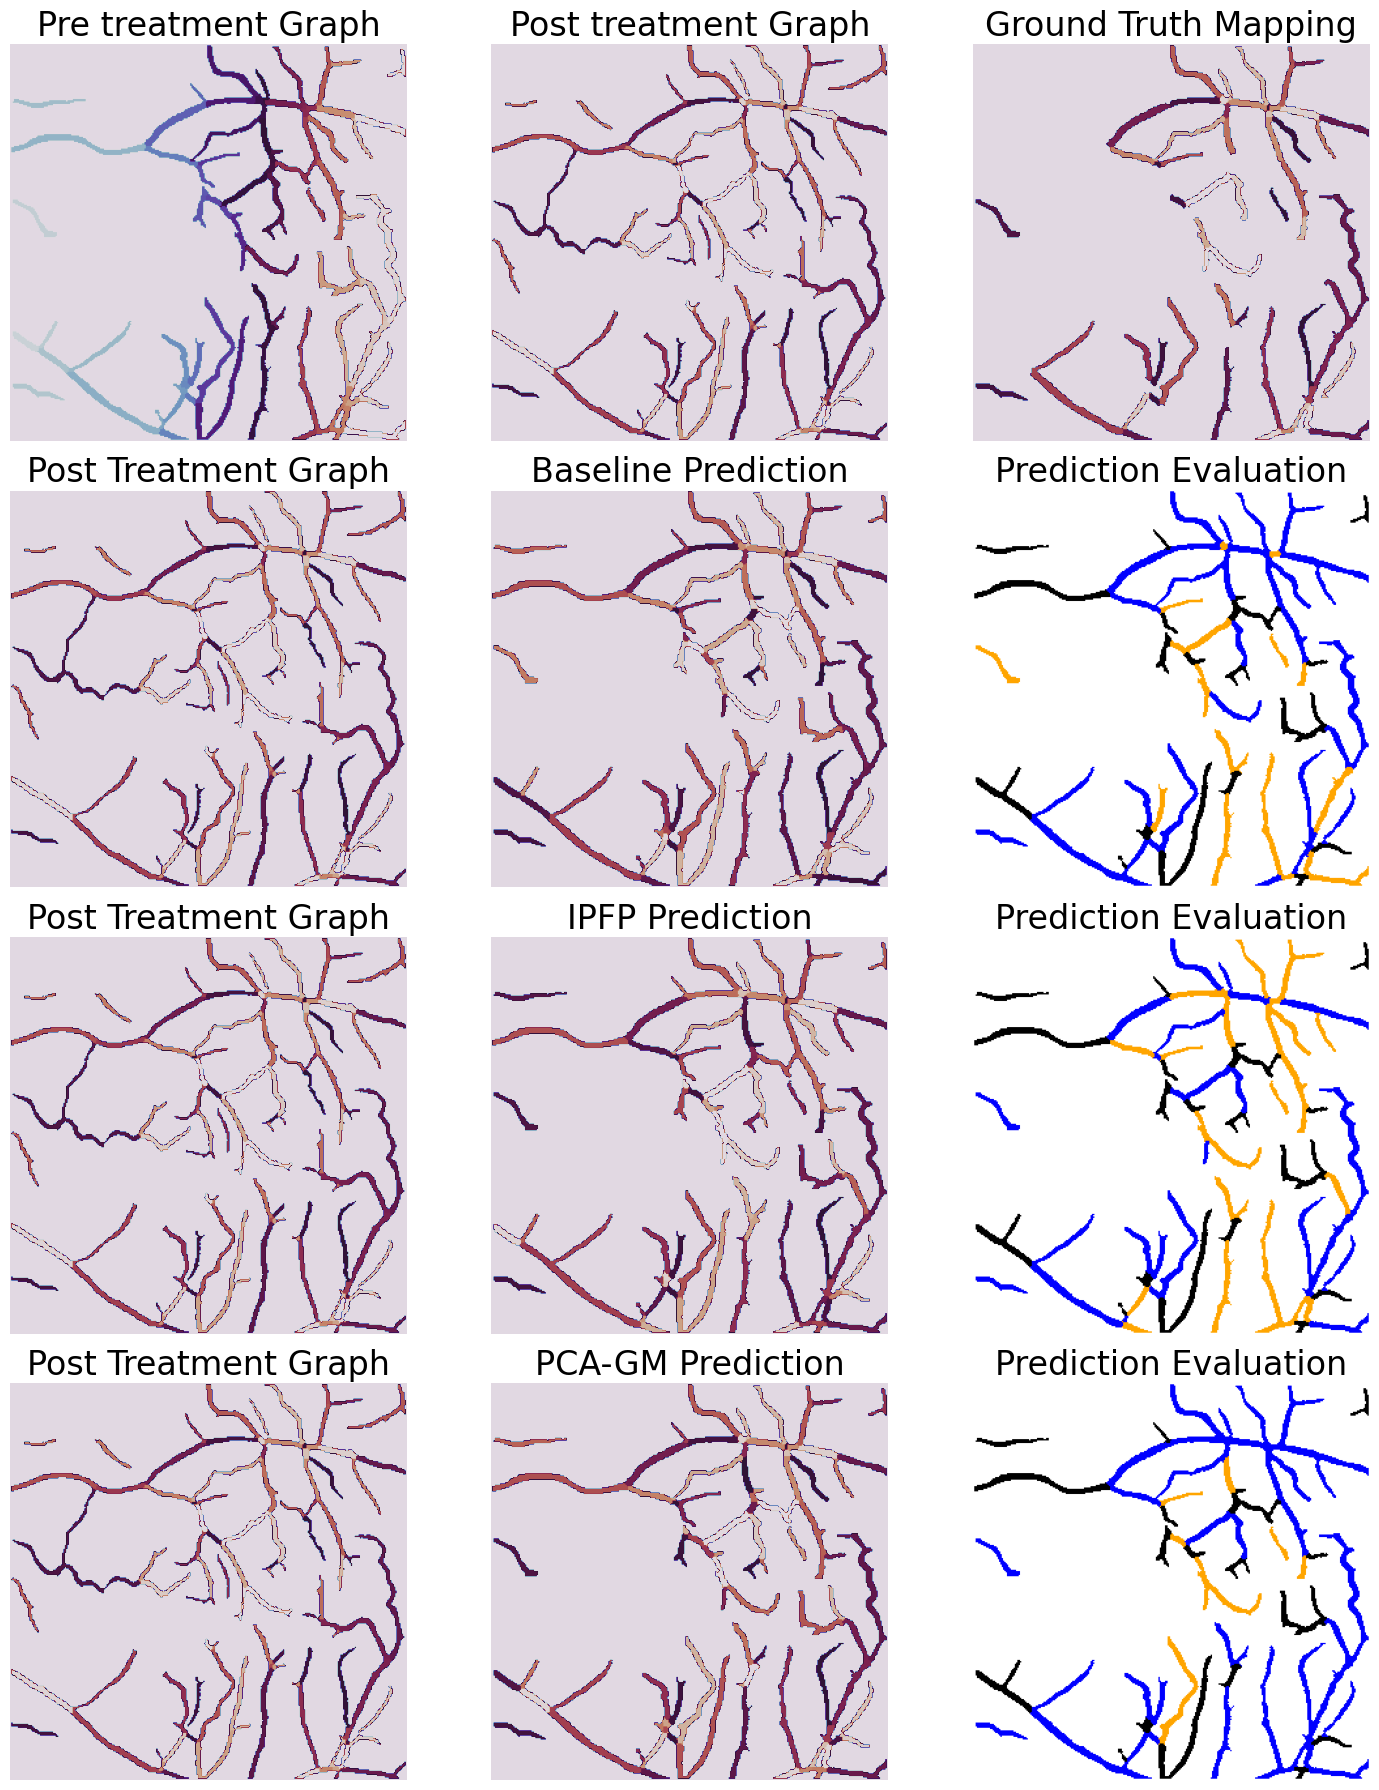

In [109]:
models = ['baseline', 'ipfp', 'pca_gm']
model_names = ['Baseline', 'IPFP', 'PCA-GM', ]
dir_models = ['baseline', 'pygm_classic', 'pygm_neural']



idx = 63
augmented_seg_idx = str(idx)
original_seg_idx= str(idx)+'_'+str(1)
gt_name = str(idx)

src_dir = '../data/soul_longitudinal'

# Load the transformed img graph data
seg = np.array(Image.open(os.path.join(src_dir, 'segmentations', augmented_seg_idx + '.png')))
edges_file = os.path.join(src_dir, 'graph_extracted_full', augmented_seg_idx + '_full_edges.csv')
json_dir = os.path.join(src_dir, 'graph_extracted_full', augmented_seg_idx + '_full_graph_filtered.json')
data_edges_graph, json_edges = _load_data_graph(edges_file, json_dir)
vessels_pts_graph, bif_pts_graph = get_info_graph(data_edges_graph, json_edges)

color_graph = colored_graph(os.path.join(src_dir, 'segmentations', augmented_seg_idx + '.png'), json_dir)
labels_1 = np.arange(100, 100 + len(vessels_pts_graph))
#np.random.seed(42)
np.random.shuffle(labels_1)
graph1_label_cl, graph1_to_labels1 = labeled_cl_graph(color_graph, vessels_pts_graph, labels_1)
graph1_labeled_img = labeled_image(seg, graph1_label_cl)

# Load the original img graph data
seg_T = np.array(Image.open(os.path.join(src_dir, 'transformed_images', original_seg_idx + '.png')))
edges_file_T = os.path.join(src_dir, 'graph_extracted_full', original_seg_idx + '_full_edges.csv')
json_dir_T = os.path.join(src_dir, 'graph_extracted_full', original_seg_idx + '_full_graph_filtered.json')
data_edges_graph_T, json_edges_T = _load_data_graph(edges_file_T, json_dir_T)
vessels_pts_graph_T, bif_pts_graph_T = get_info_graph(data_edges_graph_T, json_edges_T)

color_graph_T = colored_graph(os.path.join(src_dir, 'transformed_images', original_seg_idx + '.png'), json_dir_T)
labels2 = np.arange(100, 100 + len(vessels_pts_graph_T))
#np.random.seed(42)
np.random.shuffle(labels2)
graph2_label_cl, graph2_to_labels2 = labeled_cl_graph(color_graph_T, vessels_pts_graph_T, labels2)
graph2_labeled_img = labeled_image(seg_T, graph2_label_cl)


# Load the ground truth 
gt_dir = os.path.join(src_dir, 'gt', gt_name + '_1.npy')
gt = np.load(gt_dir)
gt_1_to_2 = idxs_gt(torch.from_numpy(gt))

gt_graph2 = np.zeros(graph2_labeled_img.shape) 
for vessel1, vessel2 in gt_1_to_2.items():
    label1 = graph1_to_labels1[vessel1]
    label2 = graph2_to_labels2[vessel2]
    gt_graph2[graph1_labeled_img==label1] = label2

# Create a figure with three subplots in a row (1 row, 3 columns)
fig, axes = plt.subplots(4, 3, figsize=(15, 18)) 
# figsize sets the figure size (width, height)

# Plot the data in each subplot
axes[0,0].imshow(color_graph, cmap='twilight')
axes[0,0].set_title('Pre treatment Graph', fontsize = 24)

axes[0,1].imshow(graph2_labeled_img, cmap='twilight')
axes[0,1].set_title('Post treatment Graph', fontsize = 24)

axes[0,2].imshow(gt_graph2, cmap='twilight')
axes[0,2].set_title('Ground Truth Mapping', fontsize = 24)

i = 0
for model in models:
    # Load the predicted matrix
    pred_dir = os.path.join('GM_results_longitudinal', dir_models[i], f'{model}_matrix_results', original_seg_idx + '.npy')
    pred = np.load(pred_dir)
    pred_1_to_2 = idxs_gt(torch.from_numpy(pred))

    # Create the predicted and solution images (solution images with true and false positives)
    pred_graph1 = np.zeros_like(graph1_labeled_img) 
    #sol_graph2 = np.zeros_like(graph2_labeled_img)
    sol_graph1 = np.ones((*graph2_labeled_img.shape, 3), dtype=np.float32)

    vessels = []
    for vessel1, vessel2 in pred_1_to_2.items():
        label1 = graph1_to_labels1[vessel1]
        if vessel1 in gt_1_to_2.keys() and gt_1_to_2[vessel1] == vessel2:
            sol_graph1[graph1_labeled_img==label1] = colors.to_rgb('blue')
        elif vessel1 in gt_1_to_2.keys() and gt_1_to_2[vessel1] != vessel2:
            sol_graph1[graph1_labeled_img==label1] = colors.to_rgb('orange')
        elif vessel1 not in gt_1_to_2.keys():
            sol_graph1[graph1_labeled_img==label1] = colors.to_rgb('black')

            
        pred_graph1[graph1_labeled_img==label1] = graph2_to_labels2[vessel2]

    # Add False negatives
    for vessel1, vessel2 in gt_1_to_2.items():
        if vessel1 not in pred_1_to_2.keys():
            label1 = graph1_to_labels1[vessel1]
            sol_graph1[graph1_labeled_img==label1] = colors.to_rgb('pink')


    axes[i+1,0].imshow(graph2_labeled_img, cmap='twilight')
    axes[i+1,0].set_title('Post Treatment Graph', fontsize = 24)

    axes[i+1,1].imshow(pred_graph1, cmap='twilight')
    axes[i+1,1].set_title(f'{model_names[i]} Prediction', fontsize = 24)

    axes[i+1,2].imshow(sol_graph1)  # Overlay with some transparency
    axes[i+1,2].set_title(f'Prediction Evaluation', fontsize = 24)

    i += 1

for row in axes:
    for ax in row:
        ax.axis('off')

# Show the figure
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()
